# MuchLearningSuchWow - LSTM - Training

This notebook contains the code we used to define and train our LSTM network. The training code is based loosely on [this kernel](https://www.kaggle.com/bountyhunters/baseline-lstm-with-keras-0-7). The WRMSSE callback uses the same WRMSSE evaluator as the one used in `LSTM_Evaluation.ipynb`, which is based on [this discussion](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834). 

### Imports & Data Paths

In [1]:
import numpy as np
import pandas as pd
import pickle

from WRMSSEEvaluator import WRMSSEEvaluator

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, Callback
from keras.optimizers import Adam

import keras.backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
inputPath = "input/m5-forecasting-accuracy/"
outputPath = "output/"
modelPath = "models/"

### Constants

In [3]:
timesteps = 14 # Number of previous days that will be used to predict the next day
startDay = 1000 # Number of days at start of data that will be ignored during training
trainValDays = 28 # Number of days at the end of the training data that will be set aside for validation during training
gap = 28 # Number of days before the training validation days that will not be used for training (to avoid bias)

### Loading Data

In [4]:
with open(outputPath + "/preprocessed_train_valid_data.pkl", "rb") as f:
    df_train_valid = pickle.load(f)
with open(outputPath + "/scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [5]:
df_train = df_train_valid[:-28] # Remove validation data (the Kaggle validation data, not the part we set aside ourselves)
print(df_train.shape)

(913, 30492)


In [6]:
df_train_scaled = scaler.transform(df_train) # Scale the training data

### Create Training/Validation Data and Labels

In [7]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay - trainValDays - gap):
    X_train.append(df_train_scaled[i-timesteps:i])
    y_train.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels

X_valid = []
y_valid = []
for i in range(1913-startDay-trainValDays, 1913-startDay):
    X_valid.append(df_train_scaled[i-timesteps:i])
    y_valid.append(df_train_scaled[i][0:30490]) # Only use first 30490 columns (sales) as labels

In [8]:
del df_train_scaled

In [9]:
# Convert data to np array to be able to feed it to the model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
print(X_valid.shape)
print(y_valid.shape)

(843, 14, 30492)
(843, 30490)
(28, 14, 30492)
(28, 30490)


### LSTM Model

In [10]:
model = Sequential()

# 1D convolution layer
model.add(Conv1D(filters=32, kernel_size=7, strides=1, padding="causal",activation="relu",input_shape=(X_train.shape[1], X_train.shape[2])))

# LSTM layers
layer_1_units=150
model.add(LSTM(units = layer_1_units, return_sequences = True))
model.add(Dropout(0.1))

layer_2_units=300
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.1))

layer_3_units=400
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(units = 30490))

In [11]:
plot_model(model, modelPath + "/model.png")
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 32)            6830240   
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 150)           109800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 300)           541200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 400)               1121600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)              

### WRMSSE Evaluation Callback

In [12]:
class WRMSSECallback(Callback):
    
    def __init__( self, df_train_orginal, df_valid_original, df_calendar, df_prices,
                  timesteps, input_data, scaler, nr_days_to_predict, additional_features ):
        # Create evaluator and set all values necessary for testing & evaluation
        self.evaluator = WRMSSEEvaluator(df_train_orginal, df_valid_original, df_calendar, df_prices)
        self.timesteps = timesteps
        self.input_data = input_data
        self.scaler = scaler
        self.nr_days_to_predict = nr_days_to_predict
        self.additional_features = additional_features
        
    def test_model( self, model ):
        # Note: this function is identical to the one in LSTM_Testing.ipynb
        
        # Scale and convert input data so that it can be fed into the model
        inputs = self.scaler.transform(self.input_data)
        X_test = np.array([inputs])
    
        # Predict sales for the next nr_days_to_predict days
        predictions = []
        for j in range(0, self.nr_days_to_predict):
            predicted_sales = model.predict(X_test[:,-self.timesteps:,:]
                                                 .reshape(1, self.timesteps, 30490 + additional_features.shape[1]))
            test_input = np.column_stack((np.array(predicted_sales), self.additional_features.iloc[[j]]))
            test_input_expanded = np.expand_dims(test_input, 0)
            X_test = np.append(X_test, test_input_expanded, axis = 1)
            predicted_sales = self.scaler.inverse_transform(test_input)[:,0:30490]
            predictions.append(predicted_sales)
    
        return predictions
    
    def evaluate( self, predictions ):
        # Reshape predictions in order to feed them to the evaluator
        predictions = pd.DataFrame(data=np.array(predictions).reshape(28,30490))
        predictions = predictions.T
        predictions.columns = [f"d_{i}" for i in range (1886,1914)]
        
        # Compute and return WRMSSE
        groups, scores = self.evaluator.score(predictions)
        wrmsse_score = np.mean(scores)
        
        return wrmsse_score
    
    def on_epoch_end( self, epoch, logs=None ):
        logs = logs or {}
        # Predict using the current state of the model, compute WRMSSE, add the result to the log and print it
        predictions = self.test_model(self.model)
        wrmsse_score = self.evaluate(predictions)
        logs['val_wrmsse'] = wrmsse_score
        print("Validation WRMSSE after epoch "+str(epoch+1)+": "+str(wrmsse_score))

In [13]:
# WRMSSE evaluator requires original, non-preprocessed data
df_sales = pd.read_csv(inputPath + "/sales_train_evaluation.csv")
df_calendar = pd.read_csv(inputPath + "/calendar.csv")
df_prices = pd.read_csv(inputPath + "/sell_prices.csv")

In [14]:
# Extract original version of training and validation data (the part of the training set we set aside for validation)
df_train_original = df_sales.iloc[:, :-28-trainValDays]
df_valid_original = df_sales.iloc[:, -28-trainValDays:-28]

In [15]:
# Extract the additional features from the validation part of the (preprocessed) training data
additional_features = df_train[-28:].iloc[:, 30490:]

In [16]:
# Create WRMSSE evaluation callback
wrmsse_valid = WRMSSECallback( df_train_original, df_valid_original, df_calendar, df_prices,
                               timesteps, df_train[:-timesteps], scaler, trainValDays, additional_features)

### Training

In [17]:
# Define the loss function (RMSE)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compile the model
model.compile(optimizer = Adam(learning_rate=0.001), loss = root_mean_squared_error)

# Create callbacks that save the models with the lowest validation loss and WRMSSE score
mcp_save_loss = ModelCheckpoint(modelPath + "/lstm_model_best_loss", save_best_only=True, monitor='val_loss', mode='min')
mcp_save_wrmsse = ModelCheckpoint(modelPath + "/lstm_model_best_wrmsse", save_best_only=True, monitor='val_wrmsse', mode='min')

# Fit the model to the training set
nr_epochs = 25
batch_size = 16
history = model.fit(X_train, y_train, 
                    epochs = nr_epochs, 
                    validation_data = (X_valid, y_valid), 
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [wrmsse_valid, mcp_save_loss, mcp_save_wrmsse])

Train on 843 samples, validate on 28 samples
Epoch 1/25
843/843 [==============================] - 30s 36ms/step - loss: 0.1470 - val_loss: 0.1581
Validation WRMSSE after epoch 1: 1.1650993743155325
Epoch 2/25
843/843 [==============================] - 29s 35ms/step - loss: 0.1408 - val_loss: 0.1577
Validation WRMSSE after epoch 2: 1.210641022902779
Epoch 3/25
843/843 [==============================] - 29s 34ms/step - loss: 0.1393 - val_loss: 0.1567
Validation WRMSSE after epoch 3: 0.9591480268939708
Epoch 4/25
843/843 [==============================] - 28s 33ms/step - loss: 0.1374 - val_loss: 0.1568
Validation WRMSSE after epoch 4: 1.0515235859235863
Epoch 5/25
843/843 [==============================] - 28s 34ms/step - loss: 0.1360 - val_loss: 0.1574
Validation WRMSSE after epoch 5: 0.8760412688092458
Epoch 6/25
843/843 [==============================] - 28s 33ms/step - loss: 0.1353 - val_loss: 0.1562
Validation WRMSSE after epoch 6: 0.841748166694544
Epoch 7/25
843/843 [=============

### Saving Result

In [18]:
model.save(modelPath + "/lstm_model_final")

### Plotting Losses

In [19]:
def plot_loss(history, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, nr_epochs), history.history['loss'], label='train_loss')
    plt.plot(np.arange(0, nr_epochs), history.history['val_loss'], label='val_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
    
def plot_wrmsse(history, nr_epochs, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, nr_epochs), history.history['val_wrmsse'], label='val_wrmsse')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('WRMSSE')
    plt.legend(loc='upper right')
    plt.show()

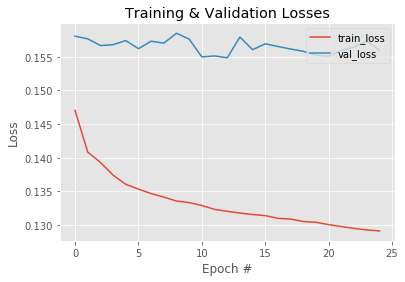

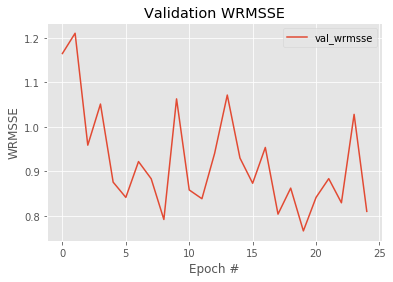

In [20]:
plot_loss(history, nr_epochs, 'Training & Validation Losses')
plot_wrmsse(history, nr_epochs, 'Validation WRMSSE')